**Introduction**

This notebook presents my analysis of an HR analytics dataset that contains features on 14,999 employees and whether they left the firm. The goal is to build a model that uses these features to predict whether a given employee has quit.  

In [26]:
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)

#data visualization
import seaborn as sns 
import matplotlib.pyplot as plt

#machine learning techniques
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

**Data Prep**

Now that we're set up, we must prep the data.

Let's take a quick look at the data.

In [27]:
df=pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


We then check for null values and take a closer look at the columns in our data set. We have two categorical columns, sales and salary. The rest are numeric. 

I also changed the dataset to show average weekly hours instead of monthly, as hours by week seems a more intuitive measurement. 

Lastly, I renamed the "sales" column to "department" to better represent the data.

In [28]:
df=df.rename(columns={'average_montly_hours':'average_weekly_hours','sales':'department'})
df['average_weekly_hours']=df['average_weekly_hours']*12/52
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_weekly_hours   14999 non-null  float64
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(3), int64(5), object(2)
memory usage: 1.1+ MB


The number of projects and average weekly hours worked features seem related, so I find the correlation coefficient to make sure they are not highly correlated with eachother (in that case, I would have removed a feature). However, a .4172 correlation coefficient does not seem high enough to warrant removal. 

In [29]:
print (np.corrcoef(df['number_project'], df['average_weekly_hours']))

[[1.         0.41721063]
 [0.41721063 1.        ]]


We can draw the following insights about the people in the dataset from analyzing the numeric variables:
* they have a relatively short tenure with the firm (average of 3.5 years, max of 10 years)
* they are generally more satisfied than not (.61 average satisfaction level)
* they are generally above average performers (.716 average rating in their last evaluation)
* 14.46% (approximately 1 in 7) of the people have had work accidents

One caveat- it's a bit hard to define relative satisfaction level and rating because we don't have a basis for comparison. For all we know, a .71 rating could just as likely correspond to a "bad" employee; maybe employers don't usually rate below that number. 
 

In [30]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_weekly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,46.396232,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,11.525331,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,22.153846,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,36.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,46.153846,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,56.538462,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,71.538462,10.000000,1.000000,1.000000,1.000000


Not too much to glean when we describe the categorical variables, besides that there are 10 departments and 3 salary bands.

In [31]:
df.describe(include=['O'])

,department,salary
count,14999,14999
unique,10,3
top,sales,low
freq,4140,7316


**Feature Selection**

We are now ready to analyze which features would be good predictors for employees leaving. A quick way to do this is by "pivoting" pairs of features, as below. Pivoting shows the average rate of leaving per band of categorical variable. Note that I analyzed the number of projects worked feature and the time spent in the firm feature here, even though both are technically numerical variables. This is because these variables contain only a few discrete values. 

Observations:

* having an accident at work does not necessarily correlate strongly with leaving the firm (8% of those who had accidents left while 26% of those who did not have accidents left)
* R&D and management depts seem to experience the least turnover, while the other departments have similar turnover rates
* Salary seems inversely correlated with how likely someone will leave
* People tend to leave when they're on a few projects or many projects. This clustering effect is seen later in a few of the other numeric variables as well.
* Workers are more likely to leave once they've spent a few years at the firm, but after 7 years everyone has stayed

Conclusions:

* We should not consider the Work_accident feature in our model
* The department feature does not seem that useful, given the similar rates between departments. However, we can leave it in for now
* We should consider salary in our model
* Include the number of projects feature, but consider turning it into a binary variable: "Normal" (between 3 and 5 projects, since the mean number of projects is 3.8) versus not
* Include the years at the firm feature, but band years 7 and onward


In [32]:
df[['Work_accident', 'left']].groupby(['Work_accident'], as_index=False).mean().sort_values(by='left')

,Work_accident,left
1,1,0.077916
0,0,0.265160


In [33]:
df[['department', 'left']].groupby(['department'], as_index=False).mean().sort_values(by='left', ascending=False)

,department,left
3,hr,0.290934
2,accounting,0.265971
9,technical,0.256250
8,support,0.248991
7,sales,0.244928
5,marketing,0.236597
0,IT,0.222494
6,product_mng,0.219512
1,RandD,0.153748
4,management,0.144444


In [34]:
df[['salary', 'left']].groupby(['salary'], as_index=False).mean().sort_values(by='left', ascending=False)

,salary,left
1,low,0.296884
2,medium,0.204313
0,high,0.066289


In [35]:
df[['number_project', 'left']].groupby(['number_project'], as_index=False).mean().sort_values(by='number_project')

,number_project,left
0,2,0.656198
1,3,0.017756
2,4,0.093700
3,5,0.221659
4,6,0.557922
5,7,1.000000


In [36]:
df[['time_spend_company', 'left']].groupby(['time_spend_company'], as_index=False).mean().sort_values(by='time_spend_company')

,time_spend_company,left
0,2,0.016338
1,3,0.246159
2,4,0.348064
3,5,0.565513
4,6,0.291086
5,7,0.000000
6,8,0.000000
7,10,0.000000


To aid with selecting numeric features, I use scatterplots.

Note that I calculate the "leave_rate" by for each instance of the numerical features by dividing the number of employees that left by the total.

Observations:
* We observe that lower satisfaction levels are associated with higher levels of turnover, as expected
* Regarding evaluation scores, it's interesting to note the two "clusters" that form; the people who leave tend to either have received low scores (.6 and below) or very high scores (.8 and above). Employees scoring in the middle rarely left. 
* A similar clustering effect is shown for the weekly hours graph as well. People tend to leave when they are overworked or underworked. We also observe that the pattern we see for the weekly hours feature is similar to that of the number of projects feature. 

Conclusions:
* Use the satisfaction_level feature in our model
* We may need to do some data wrangling on the last_evaluation feature. Consider creating two bands, exceptional scores (both really good and really bad evaluations) vs. the rest. 
* Given that both the weekly hours feature and number of projects feature exhibit a comparable clustering effect and that there is a moderate correlation between these variables (.417, as calculated earlier), I will only use the number of projects feature in my model and discard the weekly hours feature for simplicity.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


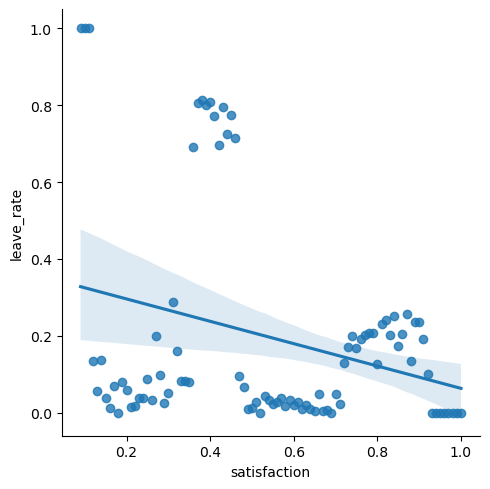

In [37]:
leave_sat=df.groupby('satisfaction_level').agg({'left': lambda x: len(x[x==1])})
leave_sat['total']=df.groupby('satisfaction_level').agg({'left': len})
leave_sat['leave_rate']=leave_sat['left']/leave_sat['total']
leave_sat['satisfaction']=df.groupby('satisfaction_level').agg({'satisfaction_level': 'mean'})
g = sns.lmplot(x='satisfaction', y='leave_rate', data=leave_sat.reset_index())

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


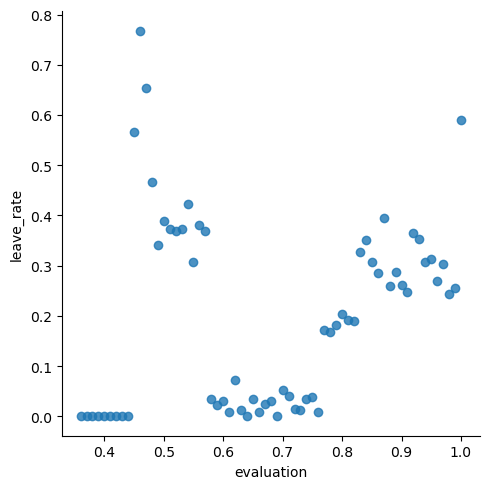

In [38]:
leave_eval=df.groupby('last_evaluation').agg({'left': lambda x: len(x[x==1])})
leave_eval['total']=df.groupby('last_evaluation').agg({'left': len})
leave_eval['leave_rate']=leave_eval['left']/leave_eval['total']
leave_eval['evaluation']=df.groupby('last_evaluation').agg({'last_evaluation': 'mean'})
gr = sns.lmplot(x='evaluation', y='leave_rate', data=leave_eval.reset_index(), fit_reg=False)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


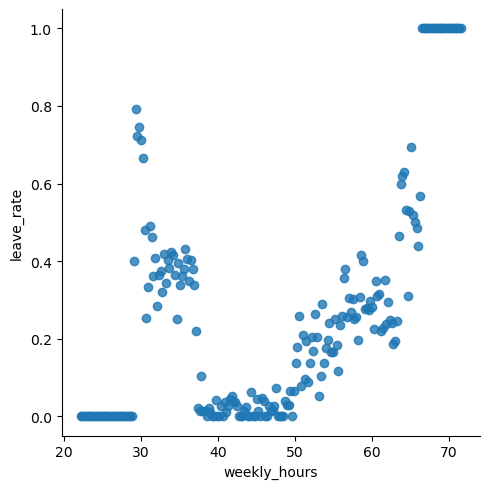

In [39]:
leave_hours=df.groupby('average_weekly_hours').agg({'left': lambda x: len(x[x==1])})
leave_hours['total']=df.groupby('average_weekly_hours').agg({'left': len})
leave_hours['leave_rate']=leave_hours['left']/leave_hours['total']
leave_hours['weekly_hours']=df.groupby('average_weekly_hours').agg({'average_weekly_hours': 'mean'})
grid=sns.lmplot( x='weekly_hours', y='leave_rate',data=leave_hours.reset_index(),fit_reg=False)

I revisit the department feature, as I think there's something more to it. In an effort to find a distinguishing element between each department, I test the relationship between an employee's department and the amount of work they do per week. My hypothesis is that some departments might work their employees harder than others, which then affects a worker's likelihood of leaving.

Observations:

* There are very minimal differences in the weekly hours worked across departments

Conclusions:

* The department feature does not seem very useful; we will not include this in our model

In [40]:
df[['department', 'average_weekly_hours']].groupby(['department'], as_index=False).mean().sort_values(by='average_weekly_hours', ascending=False)

,department,average_weekly_hours
9,technical,46.730175
0,IT,46.665225
4,management,46.442125
2,accounting,46.422224
7,sales,46.364158
1,RandD,46.338579
8,support,46.328813
6,product_mng,46.145915
5,marketing,46.012103
3,hr,45.850317


Note that I chose not to analyze the promotions feature because only 319 employees out of 14,999 were promoted. This percentage is too small for the feature to be a meaningful predictor. 

In [41]:
(df.promotion_last_5years==1).sum()
df=df.drop(['promotion_last_5years'],axis=1)

**Data Wrangling **

Now we perform the feature deletion and banding as specified earlier. To summarize:

* we drop the work_accident, department, and average_weekly_hours features
* we band the number_project, time_spend_company (years at the firm), and last_evaluation features

In [42]:
df=df.drop(['Work_accident','department','average_weekly_hours'],axis=1)
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'time_spend_company', 'left', 'salary'],
      dtype='object')

In [43]:
#banding number of projects
bins=[0,2,5,10]
names=[1,0,2]
df['abnormal_proj']=pd.cut(df['number_project'],bins,labels=names)
#banding years at the firm
bins2=[0,1,2,3,4,5,6,100]
names2=['1','2','3','4','5','6','7']
df['years_at_company']=pd.cut(df['time_spend_company'],bins2,labels=names2)
#banding last_evaluation
bins3=[0,.6,.8,1]
names3=[1,0,2]
df['abnormal_eval']=pd.cut(df['last_evaluation'],bins3,labels=names3)
df.head()

,satisfaction_level,last_evaluation,number_project,time_spend_company,left,salary,abnormal_proj,years_at_company,abnormal_eval
0,0.38,0.53,2,3,1,low,1,3,1
1,0.80,0.86,5,6,1,medium,0,6,2
2,0.11,0.88,7,4,1,medium,2,4,2
3,0.72,0.87,5,5,1,low,0,5,2
4,0.37,0.52,2,3,1,low,1,3,1


In [44]:
#cleaning up intermediary/unused columns
df=df.drop(['number_project','time_spend_company','last_evaluation'],axis=1)
df.head()

,satisfaction_level,left,salary,abnormal_proj,years_at_company,abnormal_eval
0,0.38,1,low,1,3,1
1,0.80,1,medium,0,6,2
2,0.11,1,medium,2,4,2
3,0.72,1,low,0,5,2
4,0.37,1,low,1,3,1


In [45]:
#turning all columns into numeric so that modeling algorithms can run
df['salary']=df['salary'].map({'low':0,'medium':1,'high':2}).astype(int)
pd.to_numeric(df['abnormal_proj'], errors='coerce')
pd.to_numeric(df['years_at_company'], errors='coerce')
pd.to_numeric(df['abnormal_eval'], errors='coerce')
df.head()

,satisfaction_level,left,salary,abnormal_proj,years_at_company,abnormal_eval
0,0.38,1,0,1,3,1
1,0.80,1,1,0,6,2
2,0.11,1,1,2,4,2
3,0.72,1,0,0,5,2
4,0.37,1,0,1,3,1


**Modeling**

We've finally reached the stage of training a model and using the model to make predictions. 

Our first step is to split our dataset into a training set and test set. We use an 80-20 split, as is standard. 

In [53]:
#Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

X_train, X_test, Y_train, Y_test = train_test_split(df,df['left'],test_size=.2)
X_train=X_train.drop('left',axis=1)
X_test=X_test.drop('left',axis=1)
print (X_train.shape, Y_train.shape)
print (X_test.shape, Y_test.shape)

(11999, 5) (11999,)
(3000, 5) (3000,)


We now must decide on the modelling algorithms that we want to apply. The goal of our model is to use a set of employee characteristics to label him/her as "left the firm" or "stayed". Essentially, we are looking for supervised learning algorithms that perform "classification" and "regression". The following are a few algorithms that meet these criteria:

* Logistic Regression
* KNN or k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes classifier
* Decision Tree
* 
	Random Fore
* Ada Boostn	81.00

I ultimately selected these techniques because they are relatively simple to understand.

Logistic regression is a type of regression for which the dependent variable is categorical, in this case binary. A binary logistic model predicts the likelihood of the dependent variable being one case or another (whether the employee leaves the firm or not) using the independent variables. 

The coefficients represent the level of impact each feature has on the probability of an employee leaving. For each one-unit increase in a given feature, the log-odds are scaled by that feature's coefficient.

Taking a look at the coefficients table, we see that working on an excessive number of projects (both too few or too many) and having a stellar/poor evaluation are correlated strongest with quitting the firm. Similarly, higher satisfaction and salary tend to significantly decrease the probability of leaving the firm. 

In [54]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Assuming X_train and Y_train are defined and contain your training data

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

# Create a DataFrame to store feature names and their coefficients
coeff_df = pd.DataFrame(X_train.columns, columns=['Feature'])
coeff_df["Coefficient"] = pd.Series(logreg.coef_[0])

# Sort the DataFrame by coefficient values
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

In [55]:
#Log reg
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

# Convert X_test to a numeric data type if it's not already
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')

# Check if conversion was successful
if X_test_numeric.isnull().values.any():
    # Handle missing values if any
    # You might want to impute missing values or drop columns/rows with missing values
    pass

# Predict using the logistic regression model with the converted numeric data
Y_pred = logreg.predict(X_test_numeric)
acc_log = round(logreg.score(X_test_numeric, Y_test) * 100, 2)
# Calculate precision, recall, and accuracy for each model
precision_lr = precision_score(Y_test, Y_pred)
recall_lr = recall_score(Y_test, Y_pred)
accuracy_lr = accuracy_score(Y_test, Y_pred)

# Repeat the above steps for other models like KNN, SVC, etc.

# Print the results
print("Logistic Regression - Accuracy:", accuracy_lr, "Precision:", precision_lr, "Recall:", recall_lr)
# Repeat the print statement for other models


Logistic Regression - Accuracy: 0.8033333333333333 Precision: 0.6675191815856778 Recall: 0.361997226074896


The k-Nearest Neighbors algorithm is very simple: a given employee is predicted to quit or stay based on whether the majority of the kth most similar employees have quit or stayed. The KNN algorithm scores higher than the logistic regression method. 

In [59]:
#KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

# Calculate precision, recall, and accuracy for each model
precision_knn = precision_score(Y_test, Y_pred)
recall_knn = recall_score(Y_test, Y_pred)
accuracy_knn = accuracy_score(Y_test, Y_pred)

# Repeat the above steps for other models like KNN, SVC, etc.

# Print the results
print("K-Nearest Neighbours - Accuracy:", accuracy_knn, "Precision:", precision_knn, "Recall:", recall_knn)
# Repeat the print statement for other models

K-Nearest Neighbours - Accuracy: 0.9756666666666667 Precision: 0.95 Recall: 0.9486823855755895


Support vector classification is a technique that involves constructing hyperplanes to separate data points into classes.
These hyperplanes are constructed such that the distance between the hyperplane and the nearest point of each class is maximized. The SVC algorithm scores lower than the KNN classifier. 

In [60]:
#SVM
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)

# Calculate precision, recall, and accuracy for each model
precision_svm = precision_score(Y_test, Y_pred)
recall_svm = recall_score(Y_test, Y_pred)
accuracy_svm = accuracy_score(Y_test, Y_pred)

# Repeat the above steps for other models like KNN, SVC, etc.

# Print the results
print("Support Vector Machine - Accuracy:", accuracy_svm, "Precision:", precision_svm, "Recall:", recall_svm)
# Repeat the print statement for other models


Support Vector Machine - Accuracy: 0.9476666666666667 Precision: 0.875 Recall: 0.912621359223301


The naive Bayes algorithm classifies points by using the Bayes' theorem and calculating the posteriors for each class given a vector of features. In other words, it uses probability distributions to determine whether an employee with a certain set of features is more likely to leave or stay; it then assigns the employee to the more likely class. The naive Bayes classifier scores lower than the KNN algorithm.

In [61]:
# Assuming X_train and X_test are DataFrames
# Convert string columns to numeric for X_train and X_test
X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce')
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')

# Check if conversion was successful for X_train
if X_train_numeric.isnull().values.any():
    # Handle missing values if any
    # You might want to impute missing values or drop columns/rows with missing values
    pass

# Check if conversion was successful for X_test
if X_test_numeric.isnull().values.any():
    # Handle missing values if any
    # You might want to impute missing values or drop columns/rows with missing values
    pass

# Instantiate Gaussian Naive Bayes model
gaussian = GaussianNB()

# Fit the GaussianNB model with the converted numeric training data
gaussian.fit(X_train_numeric, Y_train)

# Predict using the GaussianNB model with the converted numeric test data
Y_pred = gaussian.predict(X_test_numeric)

# Calculate the accuracy of the model on the test data
acc_gaussian = round(gaussian.score(X_test_numeric, Y_test) * 100, 2)

# Calculate precision, recall, and accuracy for each model
precision_nb = precision_score(Y_test, Y_pred)
recall_nb = recall_score(Y_test, Y_pred)
accuracy_nb = accuracy_score(Y_test, Y_pred)

# Repeat the above steps for other models like KNN, SVC, etc.

# Print the results
print("GaussianNB - Accuracy:", accuracy_nb, "Precision:", precision_nb, "Recall:", recall_nb)
# Repeat the print statement for other models

# Print the accuracy
print("Accuracy of Gaussian Naive Bayes model:", acc_gaussian)


GaussianNB - Accuracy: 0.868 Precision: 0.7473363774733638 Recall: 0.680998613037448
Accuracy of Gaussian Naive Bayes model: 86.8


The decision tree algorithm classifies points by iteratively partioning the dataset into branches based on features. For classification trees, the ending nodes are called "leaves", in which points are assigned a label. For each level of the tree, the algorithm splits the data using the feature that provides the most optimal split. The decision tree algorithm scores the highest among the five that we used. 

In [62]:
#Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
# Calculate precision, recall, and accuracy for each model
precision_dt = precision_score(Y_test, Y_pred)
recall_dt = recall_score(Y_test, Y_pred)
accuracy_dt = accuracy_score(Y_test, Y_pred)

# Repeat the above steps for other models like KNN, SVC, etc.

# Print the results
print("Decision Tree - Accuracy:", accuracy_dt, "Precision:", precision_dt, "Recall:", recall_dt)
# Repeat the print statement for other models
# Print the accuracy
print("Accuracy of Decision Tree model:", acc_decision_tree)

Decision Tree - Accuracy: 0.975 Precision: 0.9473684210526315 Recall: 0.9486823855755895
Accuracy of Decision Tree model: 98.54


We print out the decision tree below to see which features were selected to partition the dataset at each level of the tree. Feature X[2] (which corresponds to abnormal_proj) is chosen as the "best" separator, followed by X[3] and X[0], which refer to the satisfaction level and years worked at the company, respectively. I only print out the first 4 levels due to the tree's enormous size.

Note that this result mostly aligns with the coefficients output of our logistic regression algorithm, which also listed the abnormal_proj and satisfaction_level features as good predictors of employee turnover. On the other hand, despite being a good separator in the decision tree algorithm, the years worked feature had a low logistic regression coefficient (in absolute terms). We must note, however, the dangers of comparing these outputs like so. The logistic regression coefficients denote how significantly the odds of an employee leaving will change from a one-unit change in the features; since the years worked feature is inherently larger in value than the other features (which are either binary or from 0 to 1), the coefficients are less telling of a feature's predictive power than we might otherwise assume.

In [63]:
#modelling raandom forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
# Calculate precision, recall, and accuracy for each model
precision_rf = precision_score(Y_test, Y_pred)
recall_rf = recall_score(Y_test, Y_pred)
accuracy_rf = accuracy_score(Y_test, Y_pred)

# Repeat the above steps for other models like KNN, SVC, etc.

# Print the results
print("Random Forest - Accuracy:", accuracy_rf, "Precision:", precision_rf, "Recall:", recall_rf)
# Repeat the print statement for other models
print("Accuracy of Random Forest model:", acc_random_forest)

Random Forest - Accuracy: 0.978 Precision: 0.9593267882187938 Recall: 0.9486823855755895
Accuracy of Random Forest model: 98.53


In [66]:
from sklearn.ensemble import AdaBoostClassifier
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, Y_train)
Y_pred = ada_boost.predict(X_test)
acc_ada_boost = round(ada_boost.score(X_train, Y_train) * 100, 2)

# Calculate precision, recall, and accuracy for each model
precision_ada = precision_score(Y_test, Y_pred)
recall_ada = recall_score(Y_test, Y_pred)
accuracy_ada = accuracy_score(Y_test, Y_pred)

# Repeat the above steps for other models like KNN, SVC, etc.

# Print the results
print("Ada Boost - Accuracy:", accuracy_ada, "Precision:", precision_ada, "Recall:", recall_ada)

Ada Boost - Accuracy: 0.9496666666666667 Precision: 0.8980446927374302 Recall: 0.8918169209431346


**Model Evaluation**

We now summarize the models we used and rank them based on their accuracy. The decision trees algorithm scored the highest, predicting 98% of the test set's employees' decisions to leave.

In [67]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Naive Bayes', 'Decision Tree',"Random Forest","Ada Boost"],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_gaussian,acc_decision_tree,acc_random_forest,acc_ada_boost]})
models.sort_values(by='Score', ascending=False)

,Model,Score
4,Decision Tree,98.54
5,Random Forest,98.53
1,KNN,97.82
0,Support Vector Machines,94.68
6,Ada Boost,94.05
3,Naive Bayes,86.80
2,Logistic Regression,80.33


In [68]:
#Create a pandas DataFrame to display the results
modelsDD = pd.DataFrame({
    'Model': ['Ada Boost', 'Random Forest', 'SVM', 'Gaussian Naive Bias', 'Decision Tree', 'KNN', 'Logistic Regression'],
    'Accuracy': [accuracy_ada, accuracy_rf, accuracy_svm, accuracy_nb, accuracy_dt, accuracy_knn, accuracy_lr],
    'Precision': [precision_ada, precision_rf, precision_svm, precision_nb, precision_dt, precision_knn, precision_lr],
    'Recall': [recall_ada, recall_rf, recall_svm, recall_nb, recall_dt, recall_knn, recall_lr]
})

# Sort the DataFrame by accuracy score in descending order
modelsDD.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall
1,Random Forest,0.978000,0.959327,0.948682
5,KNN,0.975667,0.950000,0.948682
4,Decision Tree,0.975000,0.947368,0.948682
0,Ada Boost,0.949667,0.898045,0.891817
2,SVM,0.947667,0.875000,0.912621
3,Gaussian Naive Bias,0.868000,0.747336,0.680999
6,Logistic Regression,0.803333,0.667519,0.361997


In [69]:
#Create a pandas DataFrame to display the results
modelsDD = pd.DataFrame({
    'Model': ['Ada Boost', 'Random Forest'],
    'Accuracy': [accuracy_ada, accuracy_rf],
    'Precision': [precision_ada, precision_rf,],
    'Recall': [recall_ada, recall_rf,]
})

# Sort the DataFrame by accuracy score in descending order
modelsDD.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall
1,Random Forest,0.978000,0.959327,0.948682
0,Ada Boost,0.949667,0.898045,0.891817
